In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import eli5
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from matplotlib.ticker import MaxNLocator
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
#Functions
def weighStats(row, dayWeight, locWeight):
    weight = 1 
    if row['DayNum'] > (132 * 0.75):
        weight += dayWeight
    if (row['WLoc'] == "A") or (row['WLoc'] == "N"):
        weight += locWeight
    # print(row)
    
    # Weighting winner stats
    row['Wsos'] = row['Wsos'] * weight
    row['Wposs'] = row['Wposs'] * weight
    row['Wshoot_eff'] = row['Wshoot_eff'] * weight 
    row['Wscore_op'] = row['Wscore_op'] * weight 
    row['Woff_rtg'] = row['Woff_rtg'] * weight 
    row['Wdef_rtg'] = row['Wdef_rtg'] * weight 
    row['Wts_pct'] = row['Wts_pct'] * weight 
    row['Wefg_pct'] = row['Wefg_pct'] * weight 
    row['Worb_pct'] = row['Worb_pct'] * weight 
    row['Wdrb_pct'] = row['Wdrb_pct'] * weight 
    row['Wreb_pct'] = row['Wreb_pct'] * weight 
    row['Wto_poss'] = row['Wto_poss'] * weight 
    row['Wft_rate'] = row['Wft_rate'] * weight 
    row['Wast_rtio'] = row['Wast_rtio'] * weight
    row['Wblk_pct'] = row['Wblk_pct'] * weight
    row['Wstl_pct'] = row['Wstl_pct'] * weight
    
    # Weighting Losses
#     row['Lposs'] = row['Lposs'] * weight
#     row['Lshoot_eff'] = row['Lshoot_eff'] * weight
#     row['Lscore_op'] = row['Lscore_op'] * weight
#     row['Loff_rtg'] = row['Loff_rtg'] * weight
#     row['Ldef_rtg'] = row['Ldef_rtg'] * weight
#     row['Lts_pct'] = row['Lts_pct'] * weight
#     row['Lefg_pct'] = row['Lefg_pct'] * weight
#     row['Lorb_pct'] = row['Lorb_pct'] * weight
#     row['Ldrb_pct'] = row['Ldrb_pct'] * weight
#     row['Lreb_pct'] = row['Lreb_pct'] * weight
#     row['Lto_poss'] = row['Lto_poss'] * weight
#     row['Lft_rate'] = row['Lft_rate'] * weight
#     row['Last_rtio'] = row['Last_rtio'] * weight
#     row['Lblk_pct'] = row['Lblk_pct'] * weight
#     row['Lstl_pct'] = row['Lstl_pct'] * weight
    return row


def calcAverages(df):
    df_avg = pd.DataFrame()

    df_avg['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
    df_avg['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

    df_avg['n_loss'].fillna(0, inplace=True)

    # Calculate win percentages:
    df_avg['win_pct'] = df_avg['n_wins'] / (df_avg['n_wins'] + df_avg['n_loss'])
    # Calculate averages for games won:
    df_avg['Wshoot_eff'] = df['Wshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wscore_op'] = df['Wscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Woff_rtg'] = df['Woff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wdef_rtg'] = df['Wdef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wsos'] = df['Wsos'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wts_pct'] = df['Wts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wefg_pct'] = df['Wefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Worb_pct'] = df['Worb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wdrb_pct'] = df['Wdrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wreb_pct'] = df['Wreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wto_poss'] = df['Wto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wft_rate'] = df['Wft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wie'] = df['Wie'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wast_rtio'] = df['Wast_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wblk_pct'] = df['Wblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Wstl_pct'] = df['Wstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()

    # Calculate averages for games lost:
    df_avg['Lshoot_eff'] = df['Lshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lscore_op'] = df['Lscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Loff_rtg'] = df['Loff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Ldef_rtg'] = df['Ldef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lsos'] = df['Lsos'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lts_pct'] = df['Lts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lefg_pct'] = df['Lefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lorb_pct'] = df['Lorb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Ldrb_pct'] = df['Ldrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lreb_pct'] = df['Lreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lto_poss'] = df['Lto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lft_rate'] = df['Lft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lie'] = df['Lie'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Last_rtio'] = df['Last_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lblk_pct'] = df['Lblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
    df_avg['Lstl_pct'] = df['Lstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()

    df_avg.reset_index(inplace = True)
    df_avg = df_avg.rename(columns={'Wshoot_eff':'shoot_eff', 'Wscore_op':'score_op', 
                                    'Woff_rtg':'off_rtg', 'Wdef_rtg':'def_rtg', 'Wsos':'sos', 
                                    'Wie':'ie', 'Wts_pct':'ts_pct', 'Wefg_pct':'efg_pct', 'Worb_pct':'orb_pct', 
                                    'Wdrb_pct':'drb_pct', 'Wreb_pct':'reb_pct', 'Wto_poss':'to_poss', 
                                    'Wft_rate':'ft_rate', 'Wast_rtio':'ast_rtio', 
                                    'Wblk_pct':'blk_pct', 'Wstl_pct':'stl_pct'})
    df_avg = df_avg.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
    return df_avg


def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

def predictMatches(clf, df_predict, df_features, year):
    diff = []
    data = []

    for i, row in df_predict.iterrows():
        year, team1, team2 = get_year_t1_t2(row.ID)
#         print("Year: {}; Team1: {}; Team2: {}".format(year, team1, team2))
#         Save 2018 stats/features for the first ID:
        team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

        # Save 2018 stats/features for the first ID:
        team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]   

        diff = team1 - team2

        data.append(diff)

    n_poss_games = len(df_predict)
    columns = df_features.columns.get_values()
#     print(columns)
    final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
    final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)
    predictions = clf.predict_proba(final_predictions)[:, 1]
#     predLogLoss = log_loss(y_test, search.predict_proba(final_predictions))
    clipped_predictions = np.clip(predictions, 0.05, 0.95)
    df_predict.Pred = clipped_predictions
    
    return df_predict


# Source: https://www.kaggle.com/goodspellr/how-to-score-your-own-predictions-and-more
def kaggle_clip_log(x):
    '''
    Calculates the natural logarithm, but with the argument clipped within [1e-15, 1 - 1e-15]
    '''
    return np.log(np.clip(x,1.0e-15, 1.0 - 1.0e-15))

def kaggle_log_loss(pred, result):
    '''
    Calculates the kaggle log loss for prediction pred given result result
    '''
    return -(result*kaggle_clip_log(pred) + (1-result)*kaggle_clip_log(1.0 - pred))
    
def score_submission(df_sub, df_results, on_season=None, return_df_analysis=True):
    '''
    Scores a submission against relevant tournament results
    
    Parameters
    ==========
    df_sub: Pandas dataframe containing predictions to be scored (must contain a column called 'ID' and 
            a column called 'Pred')
            
    df_results: Pandas dataframe containing results to be compared against (must contain a column 
            called 'ID' and a column called 'Result')
            
    on_season: array-like or None.  If array, should contain the seasons for which a score should
            be calculated.  If None, will use all seasons present in df_results
            
    return_df_analysis: Bool.  If True, will return the dataframe used for calculations.  This is useful
            for future analysis
            
    Returns
    =======
    df_score: pandas dataframe containing the average score over predictions that were scorable per season
           as well as the number of obvious errors encountered
    df_analysis:  pandas dataframe containing information about all results used in scoring
                  Only provided if return_df_analysis=True
    '''
    
    df_analysis = df_results.copy()
    
    # this will overwrite if there's already a season column but it should be the same
    df_analysis['Season'] = [int(x.split('_')[0]) for x in df_results['ID']]
    
    if not on_season is None:
        df_analysis = df_analysis[np.in1d(df_analysis['Season'], on_season)]
        
    # left merge with the submission.  This will keep all games for which there
    # are results regardless of whether there is a prediction
    df_analysis = df_analysis.merge(df_sub, how='left', on='ID')
    
    # check to see if there are obvious errors in the predictions:
    # Obvious errors include predictions that are less than 0, greater than 1, or nan
    # You can add more if you like
    df_analysis['ObviousError'] = 1*((df_analysis['Pred'] < 0.0) \
                                  | (df_analysis['Pred'] > 1.0) \
                                  | (df_analysis['Pred'].isnull()))
    
    df_analysis['LogLoss'] = kaggle_log_loss(df_analysis['Pred'], df_analysis['Result'])
    
    df_score = df_analysis.groupby('Season').agg({'LogLoss' : 'mean', 'ObviousError': 'sum'})
    
    if return_df_analysis:
        return df_score, df_analysis
    else:
        return df_score
    
def convertTourneyRound(dayNum):
    """
    Consolidate tournament rounds into meaningful info.
    """
    if (dayNum == 136) | (dayNum == 137):
        return 64
    elif (dayNum == 138) | (dayNum == 139):
        return 32
    elif (dayNum == 143) | (dayNum == 144):
        return 16
    elif (dayNum == 145) | (dayNum == 146):
        return 8
    elif dayNum == 152:
        return 4
    elif dayNum == 154:
        return 2
    else:
        return 68

###### Column names
* WFGM - field goals made (by the winning team)
* WFGA - field goals attempted (by the winning team)
* WFGM3 - three pointers made (by the winning team)
* WFGA3 - three pointers attempted (by the winning team)
* WFTM - free throws made (by the winning team)
* WFTA - free throws attempted (by the winning team)
* WOR - offensive rebounds (pulled by the winning team)
* WDR - defensive rebounds (pulled by the winning team)
* WAst - assists (by the winning team)
* WTO - turnovers committed (by the winning team)
* WStl - steals (accomplished by the winning team)
* WBlk - blocks (accomplished by the winning team)
* WPF - personal fouls committed (by the winning team)

In [4]:
stage2DataPath = 'data\\Stage2DataFiles\\'
dataPath = 'data\\'
# Read in detail tournment results from 2018 and previous
df_tourneyDetailedResults = pd.read_csv(stage2DataPath + "NCAATourneyDetailedResults.csv")
# Read in the team names and teamID
df_regularSeason_teams = pd.read_csv( stage2DataPath + "Teams.csv")
# Read in the regular season results
df_regularSeason = pd.read_csv(stage2DataPath + "RegularSeasonDetailedResults.csv")
# Read in the Tournment seed data
df_tourney_seeds = pd.read_csv(stage2DataPath + "NCAATourneySeeds.csv")
# Read in Conference information
df_team_conf = pd.read_csv(stage2DataPath + 'TeamConferences.csv')
df_conf = pd.read_csv(dataPath + "Conferences.csv")
df_tourneyCompact = pd.read_csv(stage2DataPath + "NCAATourneyCompactResults.csv")

In [5]:
df_regularSeason.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [6]:
# Dropping DayNum, WLoc, NumOT
# df_regularSeason.drop(columns={'DayNum', 'WLoc','NumOT'}, inplace=True)
# df_regularSeason.drop(columns={'NumOT'}, inplace=True)

In [7]:
df_regularSeason_conf_name = df_team_conf.merge(df_conf, on=['ConfAbbrev'])

In [8]:
# Matching up winning and losing teamIDs
win_teams = df_regularSeason_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
win_confs = df_regularSeason_conf_name.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
lose_teams = df_regularSeason_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
lose_confs = df_regularSeason_conf_name.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

In [9]:
# Merge conference and team name of winning team and losing team
df_regularSeason = df_regularSeason.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})


In [10]:
# df_regularSeason.head()

In [11]:
# Build two point Field goal information.
# Providing data includes 3 point shots in the field goal data, so FG - FG3 will get the two point field goal data.
df_regularSeason['WFGM2'] = df_regularSeason.WFGM - df_regularSeason.WFGM3
df_regularSeason['WFGA2'] = df_regularSeason.WFGA - df_regularSeason.WFGA3
df_regularSeason['LFGM2'] = df_regularSeason.LFGM - df_regularSeason.LFGM3
df_regularSeason['LFGA2'] = df_regularSeason.LFGA - df_regularSeason.LFGA3

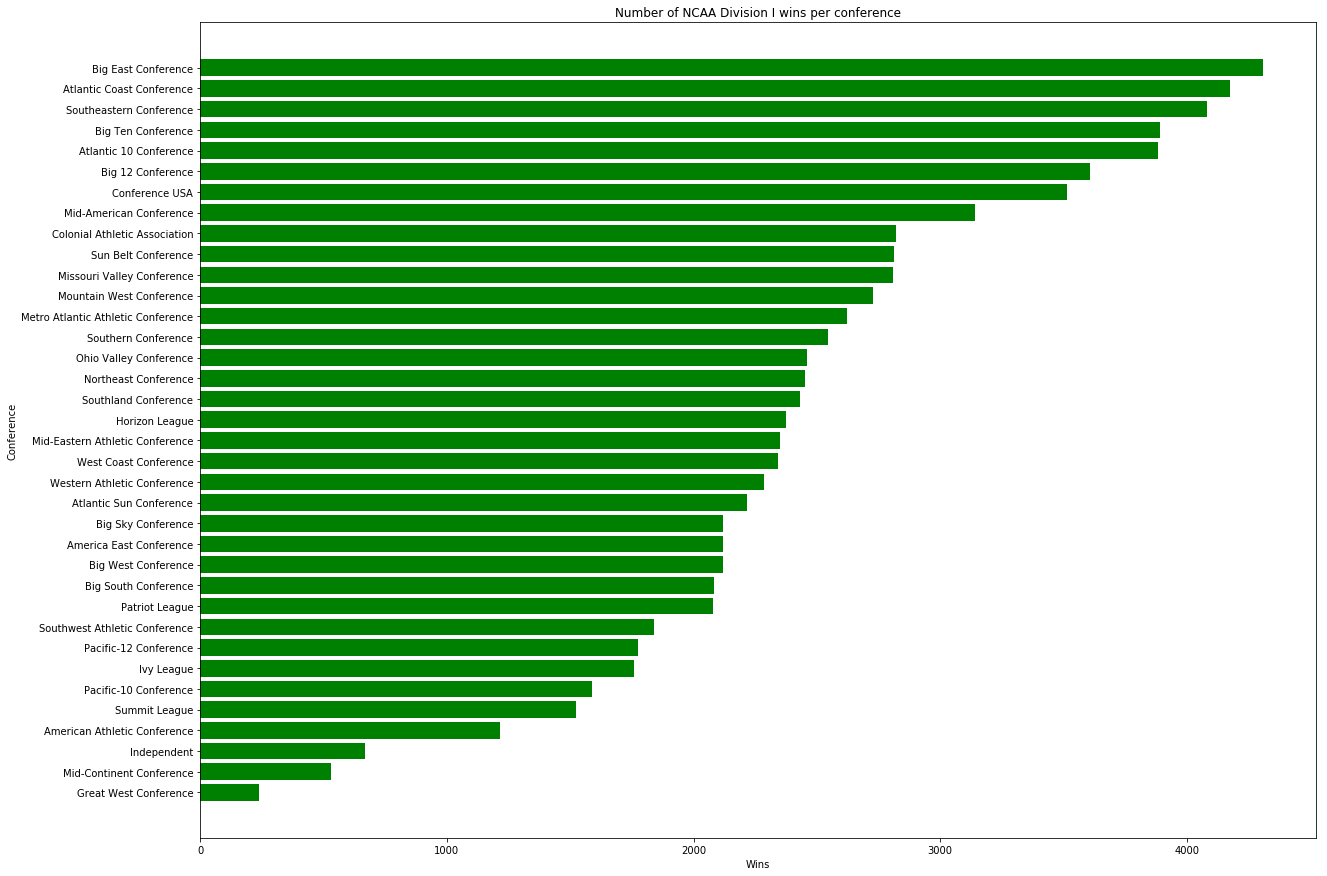

In [12]:
fig, ax = plt.subplots(figsize=(20,15))
y_bar = df_regularSeason["WConfName"].value_counts().tolist()
x_bar = df_regularSeason["WConfName"].value_counts().keys()
ax.barh(x_bar, y_bar, align='center',
        color='green', ecolor='black')
# ax.set_yticks(y_bar)
# ax.set_yticklabels(x_bar)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Wins')
ax.set_ylabel('Conference')
ax.set_title('Number of NCAA Division I wins per conference')

plt.show()

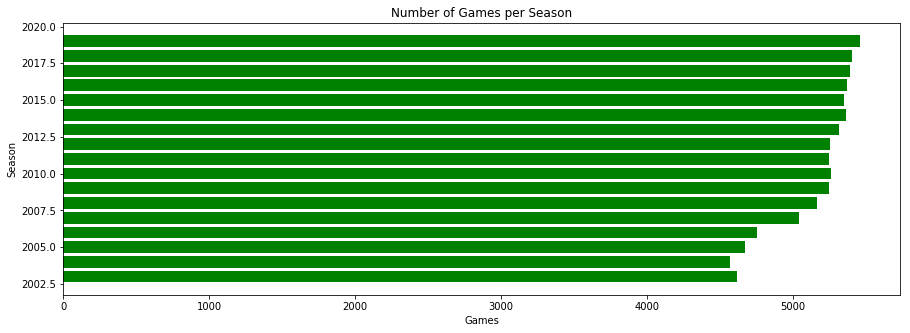

In [13]:
# temp = df_regularSeason_regularSeason.Season.value_counts().tolist()
y_bar = df_regularSeason["Season"].value_counts().tolist()
x_bar = df_regularSeason["Season"].value_counts().keys()

fig, ax = plt.subplots(figsize=(15,5))
ax.barh(x_bar, y_bar, align='center',
        color='green', ecolor='black')
# ax.set_yticks(y_bar)
# ax.set_yticklabels(x_bar)
# ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Games')
ax.set_ylabel('Season')
ax.set_title('Number of Games per Season')

plt.show()


### Feature Engineering

In [14]:
# Shooting Efficiency = Score / ( FGA + 0.475 * FTA )
# Scoring Opportunity = (FGA + 0.475 FTA)/(poss)
# Defensive Rating = opponent's offensive rating
# Offensive Rating = (score / poss) * 100
# Net Efficiency = offensive rating - opponent offensive rating

In [15]:
# Shooting features
# True Shooting percentage = ((score)/(2 * (FGA + 0.475 * FTA))) * 100
# Effective Field Goal Percentage = (FGM2 + 1.5 * FGM3) / (FGA)

In [16]:
# Rebounding features
# Offensive Rebound Percentage(orb_pct) = (OR) / (OR + opponent DR)
# Defensive Rebound Percentage(drb_pct) = (DR) / (DR + opponent OR)
# Rebound Percentage(reb_pct) = (orb_pct + drb_pct)/2

In [17]:
# Basketball on Paper author Dean Oliver outlines four factors that determine success in basketball:
# Effective Field Goal percentage
# Turnovers per possession(to_poss) = Turnovers / poss
# Offensive Rebound Percentage
# Free throw rate(ft_rate) = FTM / FGA

In [18]:
# https://stats.nba.com/help/faq/ - NBA Advanced Stats page
# Team Impact Estimate
# IE_numerator = Score + FGM + FTM - FGA - FTA + DR + 0.5 * OR + Ast + Stl + 0.5 * Blk - PF - TO
# IE = IE_numerator / (IE_Numerator + opp_IE_numerator)

# Assist Ratio(ast_rat) = (Ast / (FGA + 0.475 * FTA + TO + Ast)) * 100
# Block Percentage(blk_pct) = (Blk / opp_FGA2) * 100
# Steal Percentage(stl_pct) = (Stl / opp_poss) * 100


In [19]:
# Winner stats related to offensive efficiency:
df_regularSeason['Wposs'] = df_regularSeason.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
df_regularSeason['Wshoot_eff'] = df_regularSeason.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
df_regularSeason['Wscore_op'] = df_regularSeason.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
df_regularSeason['Woff_rtg'] = df_regularSeason.apply(lambda row: row.WScore/row.Wposs*100, axis=1)

# Loser stats related to offensive efficiency:
df_regularSeason['Lposs'] = df_regularSeason.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
df_regularSeason['Lshoot_eff'] = df_regularSeason.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
df_regularSeason['Lscore_op'] = df_regularSeason.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
df_regularSeason['Loff_rtg'] = df_regularSeason.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

# Defensive and net efficiency:
df_regularSeason['Wdef_rtg'] = df_regularSeason.apply(lambda row: row.Loff_rtg, axis=1)
df_regularSeason['Wsos'] = df_regularSeason.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
df_regularSeason['Ldef_rtg'] = df_regularSeason.apply(lambda row: row.Woff_rtg, axis=1)
df_regularSeason['Lsos'] = df_regularSeason.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

# Impact Estimate - 
# First calculate the teams' overall statistical contribution (the numerator):
Wie = df_regularSeason.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
Lie = df_regularSeason.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

# Then divide by the total game statistics (the denominator):
df_regularSeason['Wie'] = Wie / (Wie + Lie) * 100
df_regularSeason['Lie'] = Lie / (Lie + Wie) * 100

# Other winner stats:
df_regularSeason['Wts_pct'] = df_regularSeason.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
df_regularSeason['Wefg_pct'] = df_regularSeason.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
df_regularSeason['Worb_pct'] = df_regularSeason.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df_regularSeason['Wdrb_pct'] = df_regularSeason.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df_regularSeason['Wreb_pct'] = df_regularSeason.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
df_regularSeason['Wto_poss'] = df_regularSeason.apply(lambda row: row.WTO / row.Wposs, axis=1)
df_regularSeason['Wft_rate'] = df_regularSeason.apply(lambda row: row.WFTM / row.WFGA, axis=1)
df_regularSeason['Wast_rtio'] = df_regularSeason.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
df_regularSeason['Wblk_pct'] = df_regularSeason.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
df_regularSeason['Wstl_pct'] = df_regularSeason.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)

# Other loser stats:
df_regularSeason['Lts_pct'] = df_regularSeason.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
df_regularSeason['Lefg_pct'] = df_regularSeason.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
df_regularSeason['Lorb_pct'] = df_regularSeason.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
df_regularSeason['Ldrb_pct'] = df_regularSeason.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
df_regularSeason['Lreb_pct'] = df_regularSeason.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
df_regularSeason['Lto_poss'] = df_regularSeason.apply(lambda row: row.LTO / row.Lposs, axis=1)
df_regularSeason['Lft_rate'] = df_regularSeason.apply(lambda row: row.LFTM / row.LFGA, axis=1)
df_regularSeason['Last_rtio'] = df_regularSeason.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
df_regularSeason['Lblk_pct'] = df_regularSeason.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
df_regularSeason['Lstl_pct'] = df_regularSeason.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)

In [20]:
# df_regularSeason.head()

In [21]:
df_regularSeason_weighted = df_regularSeason.copy()
df_regularSeason_weighted = df_regularSeason_weighted.apply(weighStats, axis=1, args=(0.52, 0.15))

In [22]:
df_regularSeason_weighted.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Last_rtio,Lblk_pct,Lstl_pct
0,2003,10,1104,68,1328,62,N,0,27,58,...,48.857368,0.433962,0.294118,0.611111,0.452614,0.251924,0.301887,8.943544,4.545455,11.912641
1,2003,98,1400,67,1328,61,H,0,25,64,...,51.585624,0.490385,0.272727,0.581395,0.427061,0.218324,0.192308,6.400000,6.000000,7.633588
2,2003,124,1400,76,1328,71,A,0,27,50,...,50.052873,0.483333,0.348837,0.678571,0.513704,0.138621,0.216667,16.679698,15.384615,12.144213
3,2003,114,1281,67,1328,52,H,0,24,55,...,40.609137,0.318182,0.414634,0.687500,0.551067,0.189573,0.309091,9.635652,7.500000,1.765225
4,2003,70,1329,48,1328,46,H,0,19,49,...,37.022133,0.354545,0.348837,0.696970,0.522903,0.112941,0.127273,12.800000,7.317073,7.326007


In [23]:
df_regularSeason_avgs = calcAverages(df=df_regularSeason_weighted)

In [24]:
# df_regularSeason_weighted[(df_regularSeason_weighted['WTeamID'] == 1104) & (df_regularSeason_weighted['DayNum'] <= 99) & 
#                               (df_regularSeason_weighted['Season'] == 2003)]
# .groupby(df_regularSeason_weighted['Season']).sum()
# 
# temp_df.Lts_pct

In [25]:
# Calculate weighted average using win percentage:
# df_regularSeason_avgs['shoot_eff'] = df_regularSeason_avgs['Wshoot_eff'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lshoot_eff'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['score_op'] = df_regularSeason_avgs['Wscore_op'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lscore_op'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['off_rtg'] = df_regularSeason_avgs['Woff_rtg'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Loff_rtg'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['def_rtg'] = df_regularSeason_avgs['Wdef_rtg'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Ldef_rtg'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['sos'] = df_regularSeason_avgs['Wsos'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lsos'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['ts_pct'] = df_regularSeason_avgs['Wts_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lts_pct'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['efg_pct'] = df_regularSeason_avgs['Wefg_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lefg_pct'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['orb_pct'] = df_regularSeason_avgs['Worb_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lorb_pct'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['drb_pct'] = df_regularSeason_avgs['Wdrb_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Ldrb_pct'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['reb_pct'] = df_regularSeason_avgs['Wreb_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lreb_pct'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['to_poss'] = df_regularSeason_avgs['Wto_poss'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lto_poss'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['ft_rate'] = df_regularSeason_avgs['Wft_rate'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lft_rate'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['ie'] = df_regularSeason_avgs['Wie'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lie'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['ast_rtio'] = df_regularSeason_avgs['Wast_rtio'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Last_rtio'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['blk_pct'] = df_regularSeason_avgs['Wblk_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lblk_pct'] * (1 - df_regularSeason_avgs['win_pct'])
# df_regularSeason_avgs['stl_pct'] = df_regularSeason_avgs['Wstl_pct'] * df_regularSeason_avgs['win_pct'] + df_regularSeason_avgs['Lstl_pct'] * (1 - df_regularSeason_avgs['win_pct'])

# df_regularSeason_avgs.reset_index(inplace = True)
# df_regularSeason_avgs = df_regularSeason_avgs.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
# df_regularSeason_avgs.head()

In [26]:

    
df_tourneyCompact['tourn_round'] = df_tourneyCompact.DayNum.apply(convertTourneyRound)

In [27]:
df_tourneyCompact.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round
0,1985,136,1116,63,1234,54,N,0,64
1,1985,136,1120,59,1345,58,N,0,64
2,1985,136,1207,68,1250,43,N,0,64
3,1985,136,1229,58,1425,55,N,0,64
4,1985,136,1242,49,1325,38,N,0,64


In [28]:
df_tourney_seeds['seed'] = df_tourney_seeds['Seed'].apply(lambda x : int(x[1:3]))
df_tourney_seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [29]:
# Drop Seed column
df_tourney_seeds.drop(columns={'Seed'}, inplace=True)

In [30]:
df_tourney_seeds.head()

,Season,TeamID,seed
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [31]:
df_tourneyCompact = df_tourneyCompact.merge(df_tourney_seeds, how='left', 
                                                            left_on=['Season', 'WTeamID'], 
                                                            right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
.merge(df_tourney_seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

# Calculate the point differential:
df_tourneyCompact['point_diff'] = df_tourneyCompact.WScore - df_tourneyCompact.LScore

In [32]:
df_tourney_all = df_tourneyCompact[df_tourneyCompact.Season < 2018]
df_tourney_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
0,1985,136,1116,63,1234,54,N,0,64,9,8,Arkansas,Southwest Conference,Iowa,Big Ten Conference,9
1,1997,138,1246,75,1234,69,N,0,32,1,8,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,6
2,2001,138,1246,92,1234,79,N,0,32,2,7,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,13
3,1987,146,1424,84,1234,81,N,0,8,1,2,UNLV,Pacific Coast Athletic Association,Iowa,Big Ten Conference,3
4,1991,138,1181,85,1234,70,N,0,32,2,7,Duke,Atlantic Coast Conference,Iowa,Big Ten Conference,15


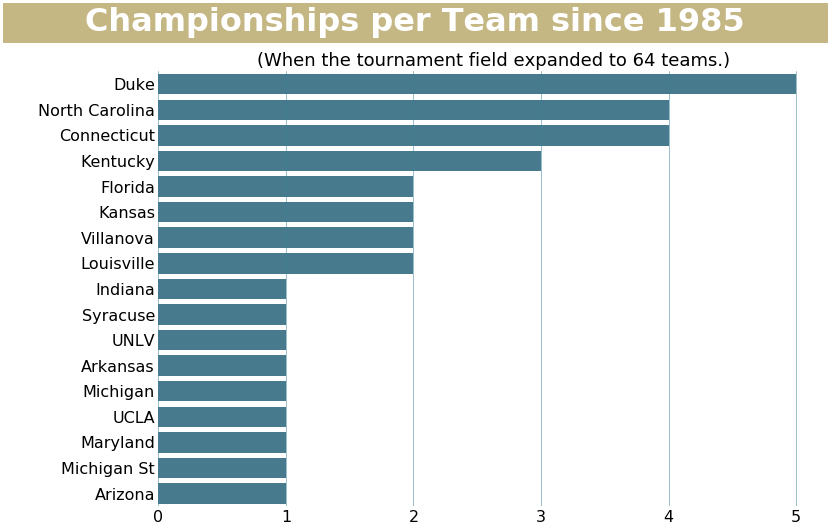

In [33]:
championships = df_tourney_all[df_tourney_all.tourn_round == 2]

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=championships.WTeamName, order=championships.WTeamName.value_counts().index, color='#3c7f99')
plt.box(False)

fig.text(x=-0.05, y=0.95, s='       Championships per Team since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

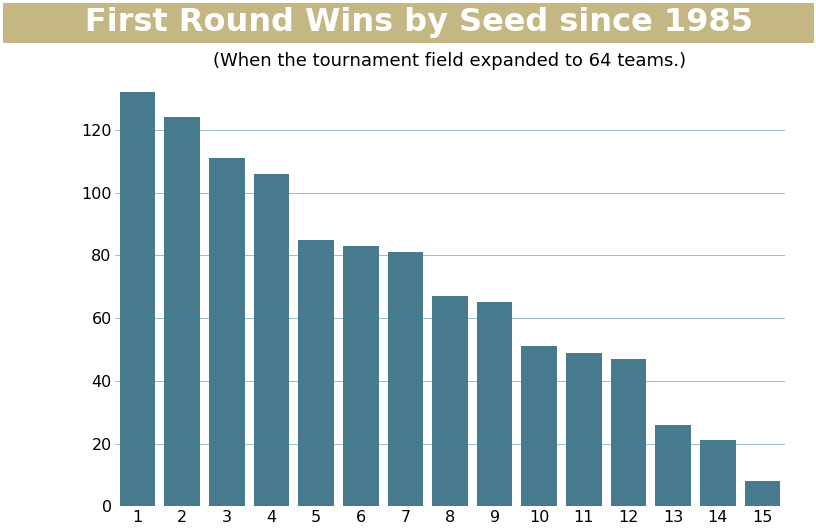

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=df_tourney_all[df_tourney_all.tourn_round == 64].Wseed, color='#3c7f99')
plt.box(False)

fig.text(x=0, y=0.95, s='       First Round Wins by Seed since 1985     ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

Text(0.5, 1.0, 'Team Impact Estimate and Win Percentage correlate at an R square of 0.379!')

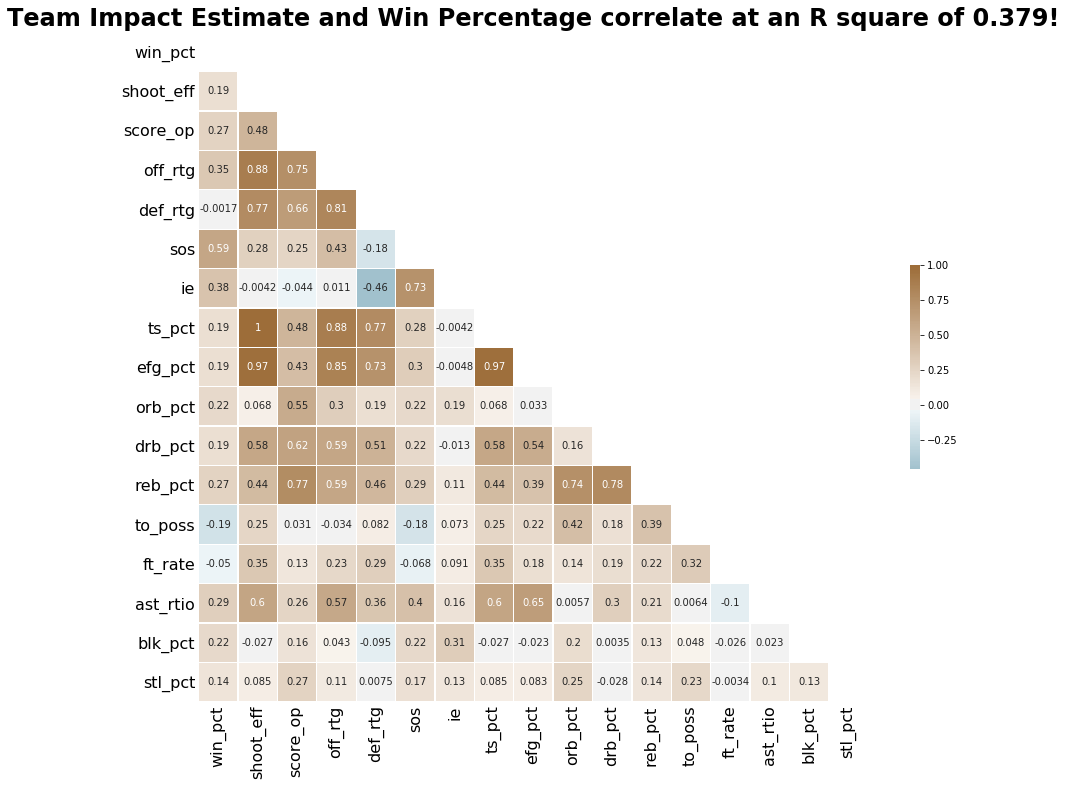

In [35]:
# Save the correlation matrix:
matrix = df_regularSeason_avgs[['win_pct', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'ts_pct', 'efg_pct', 'orb_pct', 'drb_pct', 'reb_pct', 'to_poss', 'ft_rate', 'ast_rtio', 'blk_pct', 'stl_pct']].corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

# Create mask for the upper triangle:
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create a custom diverging colormap:
cmap = sns.diverging_palette(225, 45, as_cmap=True)

sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, annot=True, square=True, linewidths=0.25, cbar_kws={'shrink': 0.25}, ax=ax)
plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)

from scipy.stats.stats import pearsonr
plt.title('Team Impact Estimate and Win Percentage correlate at an R square of {:0.3f}!'.format(pearsonr(df_regularSeason_avgs.ie, df_regularSeason_avgs.win_pct)[0]), fontsize=24, weight='bold')
# fig.text(x=0.25, y=0.75, s='In fact, Win Percentage has a moderate or strong positive \nrelationship with most of the efficiency measures.', fontsize=20)

In [36]:
# NOTES 
# https://www.kaggle.com/humburgc/history-eda-machine-learning-march-madness

In [37]:
# Feature Modeling
df_features = df_regularSeason_avgs[['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct']]
df_features.head()

,Season,TeamID,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct
0,2003,1102,1.563563,0.979372,135.645007,105.887557,29.757450,75.526345,0.780165,0.217518,0.183469,0.422285,0.446662,0.709856,78.178146,23.826618,9.131948,14.774183
1,2003,1103,1.521875,1.146790,144.619592,129.320277,15.299315,61.544613,0.721100,0.213289,0.382858,0.461164,0.560524,0.738189,76.093750,21.468632,5.880886,12.245215
2,2003,1104,1.273485,1.161428,127.433930,104.595696,22.838234,65.781984,0.596602,0.220339,0.423402,0.321776,0.621462,0.819522,63.674244,17.123303,12.698199,11.903324
3,2003,1105,1.289989,1.141217,123.810644,102.746870,21.063774,64.127665,0.591918,0.271945,0.453382,0.369371,0.627120,0.800858,64.499437,18.012492,6.434639,17.308738
4,2003,1106,1.282919,1.085897,117.345309,99.539415,17.805894,74.138235,0.616945,0.299402,0.419645,0.305639,0.630274,0.840904,64.145974,16.088693,11.251657,15.620747


In [38]:
# df_features.dtypes

In [39]:
# df_tourney_seeds.dtypes

In [40]:
df_features = pd.merge(df_tourney_seeds, df_features, how='outer', left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'])
df_features.head()
# df_features.dtypes

,Season,TeamID,seed,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct
0,1985,1207,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1985,1210,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1985,1228,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1985,1260,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1985,1374,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# df_features.head()
# df_features.dropna(inplace=True)

In [42]:
# df_features[df_features.isnull()]

In [43]:
# Merge seed data into Regular Season data

df_tourney = df_tourney_all[(df_tourney_all.Season >= 2003) & (df_tourney_all.Season < 2019)]
df_tourney.reset_index(inplace=True, drop=True)
df_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
976,2017,138,1211,79,1321,73,N,0,32,1,8,Gonzaga,West Coast Conference,Northwestern,Big Ten Conference,6
977,2005,134,1324,79,1105,69,N,0,68,16,16,Oakland,Mid-Continent Conference,Alabama A&M,Southwest Athletic Conference,10
978,2014,137,1455,64,1142,37,N,0,64,1,16,Wichita St,Missouri Valley Conference,Cal Poly SLO,Big West Conference,27
979,2011,136,1361,68,1294,50,N,0,64,2,15,San Diego St,Mountain West Conference,N Colorado,Big Sky Conference,18
980,2015,135,1352,81,1316,77,N,0,68,16,16,Robert Morris,Northeast Conference,North Florida,Atlantic Sun Conference,4


In [44]:
# Merge tournament winners season features:
df_winners = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_winners.drop(['TeamID'], inplace=True, axis=1) 

In [45]:
# Merge tournament games with features from losing team:
df_losers = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_losers.drop(['TeamID'], inplace=True, axis=1)

In [46]:
# Predicting the outcome will result in a win = 1 and a loss = 0.  
# We will model the difference in features between team A and team B

In [47]:
# Creating a dataframe for the winning teams and assigning 1 to the result column to indiciate the win.
df_winner_diff = (df_winners.iloc[:, 3:] - df_losers.iloc[:, 3:])
df_winner_diff['result'] = 1


In [48]:
# Creating a dataframe for the losing teams and assigning 0 to the result column to indiciate the loss.
df_loser_diff = (df_losers.iloc[:, 3:] - df_winners.iloc[:, 3:])
df_loser_diff['result'] = 0

In [49]:
# Combine winning team data with losing team data
df_model = pd.concat((df_winner_diff, df_loser_diff), axis=0)

In [50]:
df_model.head()

,seed,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,result
0,-5.0,0.191269,0.049779,11.639575,7.525071,4.114504,2.113075,0.082426,0.049821,0.003626,0.071032,0.062357,0.121088,9.563454,2.338344,-4.654933,0.374582,1
1,-3.0,-0.032817,0.067869,3.331642,-5.405247,8.736889,12.589617,-0.035413,0.000094,0.103793,0.082666,0.041064,-0.021665,-1.640857,-2.197814,4.496648,-4.457445,1
2,-5.0,0.138752,-0.014448,10.544626,9.180722,1.363904,0.916415,0.100436,-0.009113,-0.040407,-0.040822,-0.005889,0.028628,6.937625,1.761361,-5.872715,-3.069916,1
3,0.0,0.107670,0.112707,12.100317,7.598829,4.501488,-1.910535,0.064001,0.021358,0.036021,-0.059717,0.063816,0.091612,5.383491,0.081926,-0.549786,-0.372495,1
4,11.0,0.171230,0.179840,23.675599,29.165614,-5.490015,-10.821602,0.090019,0.003665,0.132492,0.039799,0.071183,0.009874,8.561480,2.285283,-4.728134,3.736984,1


In [51]:
# df_model.columns
# df_model.drop(columns={'seed'}, inplace=True)

In [52]:
# Select all columns except the results column 
X = df_model.iloc[:, :-1]
# Select the results column
y = df_model.result

# Split the dataframe into test and train of 25% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=42)


In [53]:
# sns.countplot(y)
# plt.xlabel(''), plt.ylabel('')
# plt.xticks([0, 1], ('losses', 'wins'))
# plt.title('The Target Classes are Balanced');

In [54]:
# Log regression
log_clf = LogisticRegression(random_state=42)
log_param_grid = {'clf__C': np.logspace(start=-80, stop=40, num=50), 'clf__penalty': ['l1', 'l2'],}


Best Parameters: {'clf__C': 2.559547922699575e+20, 'clf__penalty': 'l2'}
Training Accuracy: -0.54
Test Accuracy: -0.52
logloss: 0.5195026


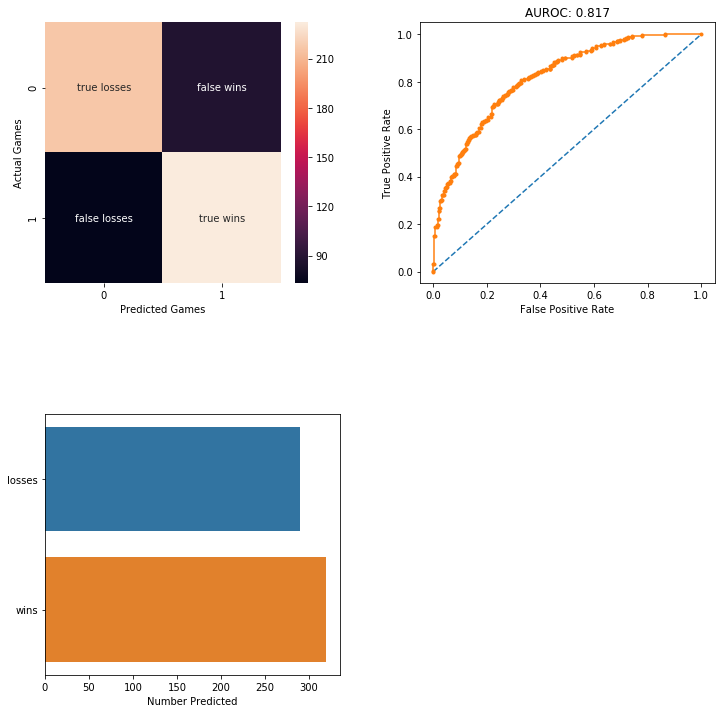

In [55]:
pipe = Pipeline([('clf', log_clf)])

# Instantiate grid search using 10-fold cross validation:
search = GridSearchCV(pipe, log_param_grid, cv=10, scoring='neg_log_loss')

# Learn relationship between predictors (basketball/tourney features) and outcome,
# and the best parameters for defining such:
search.fit(X_train, y_train)

# Predictions on the test set, new data that haven't been introduced to the model:
predicted = search.predict(X_test)

# Predictions as probabilities:
probabilities = search.predict_proba(X_test)[:, 1]
# Accuracy scores for the training and test sets:
train_accuracy = search.score(X_train, y_train)
test_accuracy = search.score(X_test, y_test)

print('Best Parameters: {}'.format(search.best_params_))
print('Training Accuracy: {:0.2}'.format(train_accuracy))
print('Test Accuracy: {:0.2}'.format(test_accuracy))

# Confusion matrix labels:
labels = np.array([['true losses','false wins'], ['false losses','true wins']])

# Model evaluation metrics:
confusion_mtrx = confusion_matrix(y_test, predicted)
auc = roc_auc_score(y_test, probabilities)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
logloss = log_loss(y_test, search.predict_proba(X_test))
print('logloss: {:0.7}'.format(logloss))

# Plot all metrics in a grid of subplots:
fig = plt.figure(figsize=(12, 12))
grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)

# Top-left plot - confusion matrix:
plt.subplot(grid[0, :2])
sns.heatmap(confusion_mtrx, annot=labels, fmt='')
plt.xlabel('Predicted Games')
plt.ylabel('Actual Games');

# Top-right plot - ROC curve:
plt.subplot(grid[0, 2:])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC: {:0.3}'.format(auc));

# Bottom-left plot - support, or true predictions:
plt.subplot(grid[1, :2])
sns.countplot(y=predicted, orient='h')
plt.yticks([1, 0], ('wins', 'losses'))
plt.ylabel(''), plt.xlabel('Number Predicted');

# Bottom-right plot - classification report:
# plt.subplot(grid[1, 2:])
# visualizer = ClassificationReport(search, classes=['losses', 'wins'])
# visualizer.fit(X_train, y_train)
# visualizer.score(X_test, y_test)
# g = visualizer.poof();


In [56]:
# Build predictions
# logloss: 0.5169117 -> no weighting
# Logloss 0.55 -> 1, Game: 0.20, Loc: 0.25
# LogLoss:  0.5160969 -> Base, 1, Game: 0.30, Loc: 0.25
# import sklearn
# sklearn.metrics.SCORERS.keys()

In [57]:
pipe = Pipeline([('clf', log_clf)])
    
lr_search = GridSearchCV(pipe, log_param_grid, cv=10)
lr_search.fit(X_train, y_train)
print("Best C: {}; Best penalty: {}".format(lr_search.best_params_['clf__C'], lr_search.best_params_['clf__penalty']))

perm = PermutationImportance(lr_search, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Best C: 0.023299518105153814; Best penalty: l1


Weight,Feature
0.1764 ± 0.0347,seed
0 ± 0.0000,orb_pct
0 ± 0.0000,shoot_eff
0 ± 0.0000,score_op
0 ± 0.0000,def_rtg
0 ± 0.0000,ie
0 ± 0.0000,efg_pct
0 ± 0.0000,to_poss
0 ± 0.0000,ft_rate
0 ± 0.0000,reb_pct


In [58]:
df_predict_pre2019 = pd.read_csv(dataPath + 'SampleSubmissionStage1.csv')
df_predictions = pd.read_csv(dataPath + 'SampleSubmissionStage2.csv')
df_predictions.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [59]:
year = 2019
predictMatches(lr_search, df_predictions, df_features, year).to_csv('best_model_results_{}.csv'.format(year), index=False)
predictMatches(lr_search, df_predict_pre2019, df_features, year).to_csv('best_model_results_pre{}.csv'.format(year), index=False)

In [60]:
from bracketeer import build_bracket

b = build_bracket(
        outputPath='best_bracket_{}.png'.format(year),
        submissionPath='best_model_results_2019.csv',
        teamsPath= stage2DataPath + 'Teams.csv',
        seedsPath= stage2DataPath + 'NCAATourneySeeds.csv',
        slotsPath= stage2DataPath + 'NCAATourneySlots.csv',
        year=year
)

In [61]:
## 2019 Predictions
from IPython.display import HTML, Image
import random
__counter__ = random.randint(0,2e9)

Image(url="best_bracket_2019.png")


In [62]:
# df_tourneyCompact
df_tc = pd.read_csv(stage2DataPath + "NCAATourneyCompactResults.csv")
df_tc['ID'] = df_tc['Season'].astype(str) + '_' \
              + (np.minimum(df_tc['WTeamID'],df_tc['LTeamID'])).astype(str) + '_' \
              + (np.maximum(df_tc['WTeamID'],df_tc['LTeamID'])).astype(str)

df_tc['Result'] = 1*(df_tc['WTeamID'] < df_tc['LTeamID'])
# df_tourneyCompact.head(10)

df_tc = df_tc.merge(df_tourney_seeds.rename(columns={'Seed':'WSeed','TeamID':'WTeamID'}), 
                    how='inner', on=['Season', 'WTeamID'])
df_tc = df_tc.merge(df_tourney_seeds.rename(columns={'Seed':'LSeed','TeamID':'LTeamID'}), 
                    how='inner', on=['Season', 'LTeamID'])
# Remove any play-in games
# df_playin = df_tc[df_tc['WSeed'].str[0:3] == df_tc['LSeed'].str[0:3]]
df_tc.head(10)
# df_tc = df_tc[df_tc['WSeed'].str[0:3] != df_tc['LSeed'].str[0:3]]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ID,Result,seed_x,seed_y
0,1985,136,1116,63,1234,54,N,0,1985_1116_1234,1,9,8
1,1985,136,1120,59,1345,58,N,0,1985_1120_1345,1,11,6
2,1985,138,1120,66,1242,64,N,0,1985_1120_1242,1,11,3
3,1985,136,1207,68,1250,43,N,0,1985_1207_1250,1,1,16
4,1985,138,1207,63,1396,46,N,0,1985_1207_1396,1,1,8
5,1985,143,1207,65,1260,53,N,0,1985_1207_1260,1,1,4
6,1985,145,1207,60,1210,54,N,0,1985_1207_1210,1,1,2
7,1985,152,1207,77,1385,59,N,0,1985_1207_1385,1,1,1
8,1985,136,1229,58,1425,55,N,0,1985_1229_1425,1,9,8
9,1985,136,1242,49,1325,38,N,0,1985_1242_1325,1,3,14


In [63]:
df_submission = pd.read_csv("best_model_results_pre2019.csv")
# df_submission.head()
df_score, df_analysis = score_submission(df_submission, df_tc, on_season = np.arange(2014,2019), return_df_analysis=True)
df_score

,LogLoss,ObviousError
Season,,
2014,0.594294,0
2015,0.504399,0
2016,0.576257,0
2017,0.513400,0
2018,0.600552,0


In [64]:
df_score['LogLoss'].mean()

0.5577806029527446